# 1

In [54]:
# Standard Libraries
import os
import time

# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

# SciPy
from scipy.spatial import procrustes
from scipy.optimize import linear_sum_assignment
from scipy.stats import pearsonr

# Scikit-learn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


# Warnings
import warnings
warnings.filterwarnings('ignore')

In [55]:
# Define a mapping for the class codes
class_mapping = {
    "I": "Igneous",
    "M": "Metamorphic",
    "S": "Sedimentary"
}

# Path to your dataset
dataset_path = "./osfstorage-archive/360 Rocks"

# Data storage
data = []

# Function to resize, downsample and convert to grayscale
def process_image(img_path, size=(100, 100), factor=0.5, grayscale=True):
    try:
        img = Image.open(img_path).convert("RGB")  # Open the image and convert to RGB
        # Resize the image
        img = img.resize(size)
        
        # Downsample the image by the given factor
        # width, height = img.size
        # new_size = (int(width * factor), int(height * factor))
        # img = img.resize(new_size)
        
        # Convert to grayscale if specified
        # if grayscale:
        #     img = img.convert('L')  # Convert image to grayscale ('L' mode)
        
        return img
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        return None

# Iterate through files
for img_file in os.listdir(dataset_path):
    if img_file.endswith(".jpg"):  # Ensure it's an image
        # Split the filename to extract class and subcategory
        parts = img_file.split("_")
        class_code = parts[0]
        subcategory = parts[1]
        rock_no = parts[2].split(".")[0]  # Remove extension

        # Get the class name from the mapping
        class_name = class_mapping.get(class_code, "Unknown")

        # Load and process the image
        img_path = os.path.join(dataset_path, img_file)
        img = process_image(img_path)  # Process the image

        if img:  # If image is processed successfully
            # Store the image and its metadata
            data.append({
                "Image": img,
                "Class": class_name,
                "SubCategory": subcategory,
                "RockNo": rock_no,
                "Filename": img_file
            })
            print(f"Loaded: {img_file} | Class: {class_name}, Subcategory: {subcategory}, Rock: {rock_no}")
        else:
            print(f"Skipping {img_file} due to error in processing.")


Loaded: I_Andesite_01.jpg | Class: Igneous, Subcategory: Andesite, Rock: 01
Loaded: I_Andesite_02.jpg | Class: Igneous, Subcategory: Andesite, Rock: 02
Loaded: I_Andesite_03.jpg | Class: Igneous, Subcategory: Andesite, Rock: 03
Loaded: I_Andesite_04.jpg | Class: Igneous, Subcategory: Andesite, Rock: 04
Loaded: I_Andesite_05.jpg | Class: Igneous, Subcategory: Andesite, Rock: 05
Loaded: I_Andesite_06.jpg | Class: Igneous, Subcategory: Andesite, Rock: 06
Loaded: I_Andesite_07.jpg | Class: Igneous, Subcategory: Andesite, Rock: 07
Loaded: I_Andesite_08.jpg | Class: Igneous, Subcategory: Andesite, Rock: 08
Loaded: I_Andesite_09.jpg | Class: Igneous, Subcategory: Andesite, Rock: 09
Loaded: I_Andesite_10.jpg | Class: Igneous, Subcategory: Andesite, Rock: 10
Loaded: I_Andesite_11.jpg | Class: Igneous, Subcategory: Andesite, Rock: 11
Loaded: I_Andesite_12.jpg | Class: Igneous, Subcategory: Andesite, Rock: 12
Loaded: I_Basalt_01.jpg | Class: Igneous, Subcategory: Basalt, Rock: 01
Loaded: I_Basalt

In [56]:
print(f"Total images loaded: {len(data)}")

Total images loaded: 360


In [57]:
rocks_360_df = pd.DataFrame(data)
rocks_360_df.head()

,Image,Class,SubCategory,RockNo,Filename
0,<PIL.Image.Image image mode=RGB size=100x100 a...,Igneous,Andesite,01,I_Andesite_01.jpg
1,<PIL.Image.Image image mode=RGB size=100x100 a...,Igneous,Andesite,02,I_Andesite_02.jpg
2,<PIL.Image.Image image mode=RGB size=100x100 a...,Igneous,Andesite,03,I_Andesite_03.jpg
3,<PIL.Image.Image image mode=RGB size=100x100 a...,Igneous,Andesite,04,I_Andesite_04.jpg
4,<PIL.Image.Image image mode=RGB size=100x100 a...,Igneous,Andesite,05,I_Andesite_05.jpg


In [58]:
# Rock class with the subcategory

pd.DataFrame(rocks_360_df[['Class', 'SubCategory']].value_counts()).sort_values(by=['Class', 'SubCategory'])

count
Class       SubCategory           
Igneous     Andesite            12
            Basalt              12
            Diorite             12
            Gabbro              12
            Granite             12
            Obsidian            12
            Pegmatite           12
            Peridotite          12
            Pumice              12
            Rhyolite            12
Metamorphic Amphibolite         12
            Anthracite          12
            Gneiss              12
            Hornfels            12
            Marble              12
            Migmatite           12
            Phyllite            12
            Quartzite           12
            Schist              12
            Slate               12
Sedimentary Bituminous Coal     12
            Breccia             12
            Chert               12
            Conglomerate        12
            Dolomite            12
            Micrite             12
            Rock Gypsum         12
            Rock Salt           12
            Sandstone           12
            Shale               12

In [59]:
rocks_360_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Image        360 non-null    object
 1   Class        360 non-null    object
 2   SubCategory  360 non-null    object
 3   RockNo       360 non-null    object
 4   Filename     360 non-null    object
dtypes: object(5)
memory usage: 14.2+ KB


In [60]:
rocks_360_df.shape

(360, 5)

In [61]:
# Flatten images and create a NumPy array
rocks_360_df['Image_Array'] = rocks_360_df['Image'].apply(lambda img: np.array(img).flatten())
rocks_360_df.head()

,Image,Class,SubCategory,RockNo,Filename,Image_Array
0,<PIL.Image.Image image mode=RGB size=100x100 a...,Igneous,Andesite,01,I_Andesite_01.jpg,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
1,<PIL.Image.Image image mode=RGB size=100x100 a...,Igneous,Andesite,02,I_Andesite_02.jpg,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
2,<PIL.Image.Image image mode=RGB size=100x100 a...,Igneous,Andesite,03,I_Andesite_03.jpg,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
3,<PIL.Image.Image image mode=RGB size=100x100 a...,Igneous,Andesite,04,I_Andesite_04.jpg,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
4,<PIL.Image.Image image mode=RGB size=100x100 a...,Igneous,Andesite,05,I_Andesite_05.jpg,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."


In [62]:
print("No of pixels in each image:",len(rocks_360_df['Image_Array'][0]))
rocks_360_df['Image_Array'][0]

No of pixels in each image: 30000


array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)

In [63]:
# Stack all the flattened images into a 2D NumPy array
image_data = np.stack(rocks_360_df['Image_Array'].values)

# Normalize the image data (optional but recommended)
image_data = image_data / 255.0

In [64]:
# Apply PCA to reduce the dimensionality of the image data
pca = PCA()
pca.fit(image_data)

# Calculate the number of components required to preserve 90% of the variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)
components_needed = np.argmax(explained_variance >= 0.90) + 1

print(f"Number of components to preserve 90% variance: {components_needed}")

Number of components to preserve 90% variance: 116


In [65]:
# Reduce the image data to the selected number of components
pca = PCA(n_components=components_needed)
reduced_data = pca.fit_transform(image_data)

# Create column names for the PCA components
reduced_columns = [f"PCA_Component_{i}" for i in range(components_needed)]

# Add the PCA components back to the DataFrame
rocks_360_df[reduced_columns] = reduced_data

rocks_360_df.head()

,Image,Class,SubCategory,RockNo,Filename,Image_Array,PCA_Component_0,PCA_Component_1,PCA_Component_2,PCA_Component_3,...,PCA_Component_106,PCA_Component_107,PCA_Component_108,PCA_Component_109,PCA_Component_110,PCA_Component_111,PCA_Component_112,PCA_Component_113,PCA_Component_114,PCA_Component_115
0,<PIL.Image.Image image mode=RGB size=100x100 a...,Igneous,Andesite,01,I_Andesite_01.jpg,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",-26.999820,19.570184,2.731322,17.547927,...,-3.040015,-0.357432,-0.579062,-1.019945,-1.363536,-0.520785,0.633361,-3.160179,-1.164314,-1.949122
1,<PIL.Image.Image image mode=RGB size=100x100 a...,Igneous,Andesite,02,I_Andesite_02.jpg,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",-5.924800,-17.655060,-20.252035,9.650112,...,-2.566157,4.307821,-0.316123,0.933891,2.474769,-0.968920,0.217643,-1.850068,0.361452,0.304156
2,<PIL.Image.Image image mode=RGB size=100x100 a...,Igneous,Andesite,03,I_Andesite_03.jpg,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",5.235502,-1.704298,-6.701375,-15.054745,...,-0.963948,-0.515150,1.696578,0.296442,0.872710,-0.233183,1.885286,-0.178157,-0.133156,-1.200620
3,<PIL.Image.Image image mode=RGB size=100x100 a...,Igneous,Andesite,04,I_Andesite_04.jpg,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",-1.911280,4.125845,4.013541,-4.771085,...,0.115926,-0.189073,-0.491452,-0.456207,0.561149,-0.901223,-0.536689,1.243155,0.697662,-0.155793
4,<PIL.Image.Image image mode=RGB size=100x100 a...,Igneous,Andesite,05,I_Andesite_05.jpg,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",27.910635,3.962757,-11.262149,-3.077919,...,-0.424331,-1.215405,-0.539637,0.669027,-0.705321,-0.581223,0.504580,-0.241063,0.854726,0.670367


### Summary

To determine the number of components required to preserve 90% of the variance using Principal Component Analysis (PCA) on the images in the '360 Rocks' dataset, the following steps were followed:

1. **Data Preprocessing**:
   - Images were resized to a uniform dimension of `(100, 100)` pixels to ensure no issues with the memory/running time.

2. **Image Flattening**:
   - Each image was flattened into a 1D vector, transforming the image data into a format suitable for PCA.

3. **Normalization**:
   - The pixel values of the images were normalized by dividing by 255. This scales the pixel values to a range of 0 to 1, ensuring that each feature (pixel) contributes equally to the PCA process.

4. **PCA Application**:
   - PCA was applied to the normalized image data, and the cumulative explained variance was computed for each principal component.

5. **Result**:
   - The number of principal components required to preserve 90% of the total variance in the dataset was found to be **116**.

Thus, **116 principal components** are needed to retain 90% of the variance in the '360 Rocks' image dataset after applying PCA.


# 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09463520668739722..1.2337456491131287].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03817079997321038..1.1826927428191891].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.18526446361626425..1.2249771411232304].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.18406284725967936..1.148628900889916].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.29673814189177594..1.1674601982739825].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.13702860161934233..1.198639601453399].
Clipping input data to

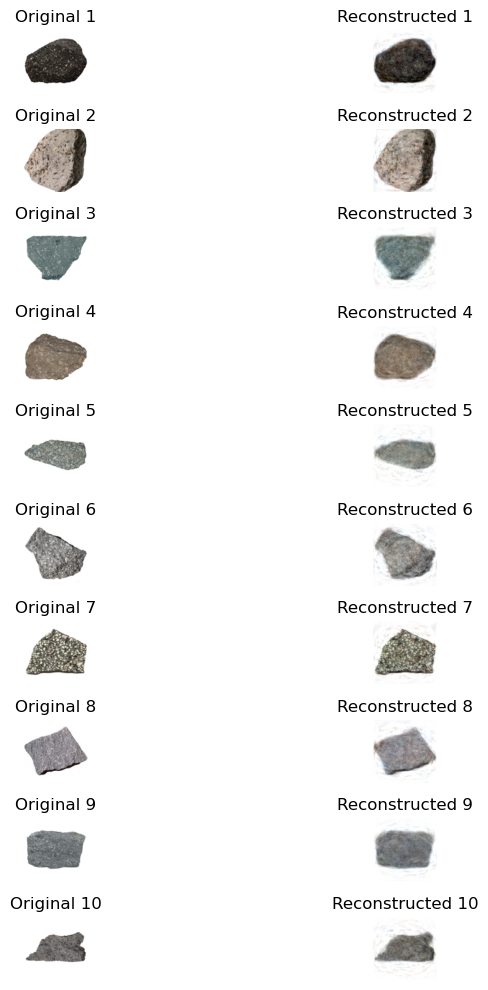

In [66]:
# Number of images to display
num_images = 10

plt.figure(figsize=(10,10))

# Select 10 random images for display (or just use the first 10)
for i in range(num_images):
    # Reshape the original image back to its 2D form (64x64x3 for this example)
    original_image = image_data[i].reshape(100, 100, 3)
    
    # Reconstruct the image using PCA
    reconstructed_image_flat = pca.inverse_transform(reduced_data[i])
    
    # Reshape the reconstructed image back to (64, 64, 3)
    reconstructed_image = reconstructed_image_flat.reshape(100, 100, 3)
    
    # Display original image
    plt.subplot(num_images, 2, 2 * i + 1)
    plt.imshow(original_image)
    plt.title(f"Original {i+1}")
    plt.axis('off')

    # Display reconstructed image
    plt.subplot(num_images, 2, 2 * i + 2)
    plt.imshow(reconstructed_image)
    plt.title(f"Reconstructed {i+1}")
    plt.axis('off')

plt.tight_layout()

plt.show()


# 3A

In [67]:
# Apply PCA to reduce the dimensionality to 2
pca_2d = PCA(n_components=2)

# Fit PCA on the flattened image data (image_data contains images reshaped to 1D arrays)
reduced_data_2d = pca_2d.fit_transform(image_data)

# Calculate the total variance explained by the first two components
explained_variance = np.sum(pca_2d.explained_variance_ratio_)

# Print the explained variance
print(f"Variance explained by the first 2 principal components: {explained_variance * 100:.2f}%")

Variance explained by the first 2 principal components: 35.42%


# 3B

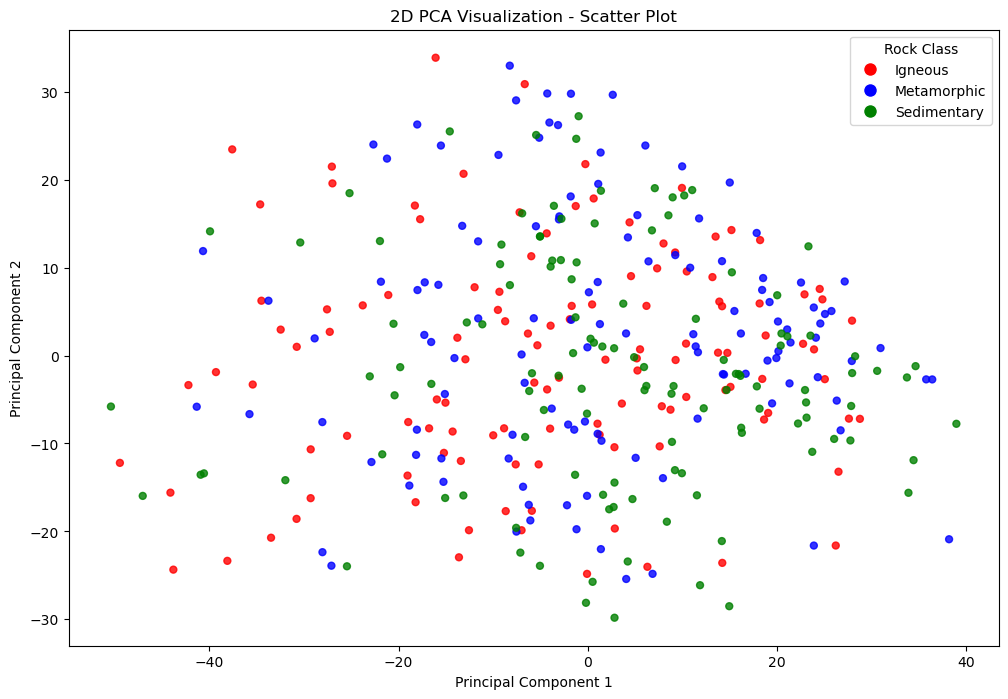

In [68]:
# 2D scatter plot of the images spanned by the first two principal components

# Define color mapping for categories
color_mapping = {
    "Igneous": "red",
    "Metamorphic": "blue",
    "Sedimentary": "green"
}

rocks_360_df['Color'] = rocks_360_df['Class'].map(color_mapping)

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    rocks_360_df['PCA_Component_0'], 
    rocks_360_df['PCA_Component_1'], 
    c=rocks_360_df['Color'], 
    label=rocks_360_df['Class'], 
    s=25, alpha=0.8
)

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label=key, markersize=10, markerfacecolor=color)
    for key, color in color_mapping.items()
]
plt.legend(handles=legend_elements, title="Rock Class", loc="best")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D PCA Visualization - Scatter Plot")
plt.show()

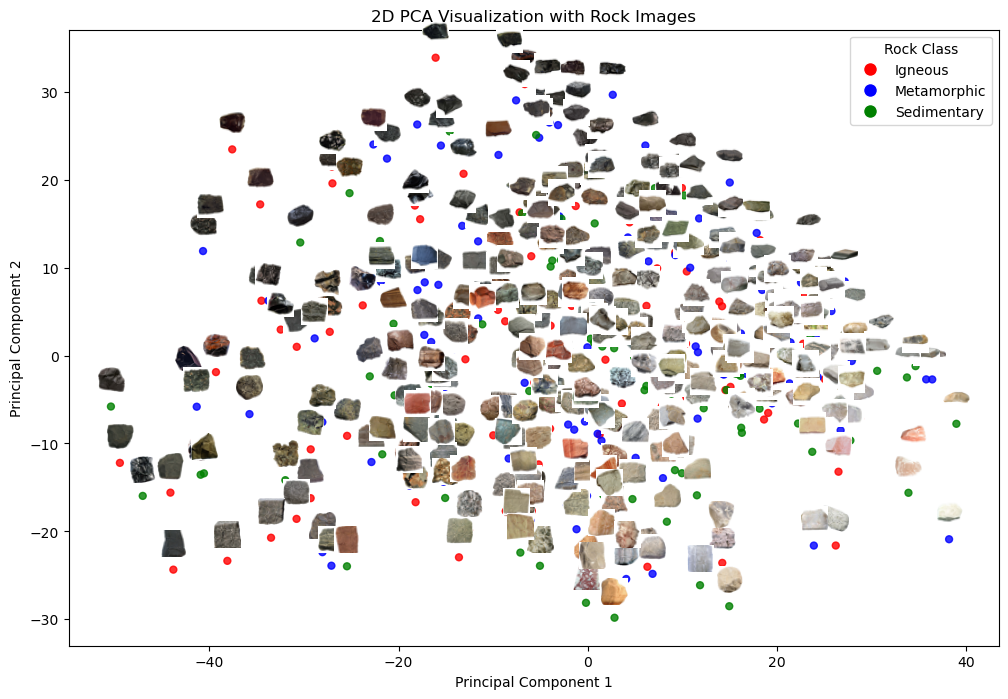

In [69]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the dots (scatter points)
scatter = ax.scatter(
    rocks_360_df['PCA_Component_0'], 
    rocks_360_df['PCA_Component_1'], 
    c=rocks_360_df['Color'], 
    s=25, alpha=0.8
)

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label=key, markersize=10, markerfacecolor=color)
    for key, color in color_mapping.items()
]
ax.legend(handles=legend_elements, title="Rock Class", loc="best")

# Define the vertical offset for the images
vertical_offset = 3  # Adjust this value as needed

# Overlay rock images above or below the dots
for i, row in rocks_360_df.iterrows():
    try:
        # Resize the image for visualization
        image = np.array(row['Image'].resize((24, 24)))  # Resize for better fit
        im = OffsetImage(image, zoom=0.8, alpha=1.0)  # Adjust zoom level for visibility
        # Position the image above the dot
        ab = AnnotationBbox(
            im, 
            (row['PCA_Component_0'], row['PCA_Component_1'] + vertical_offset),  # Offset y-coordinate (adjust + or - for above/below)
            frameon=False
        )
        ax.add_artist(ab)
    except Exception as e:
        print(f"Error adding image for {row['Filename']}: {e}")

# Set axis labels and title
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("2D PCA Visualization with Rock Images")

# Display the plot
plt.show()

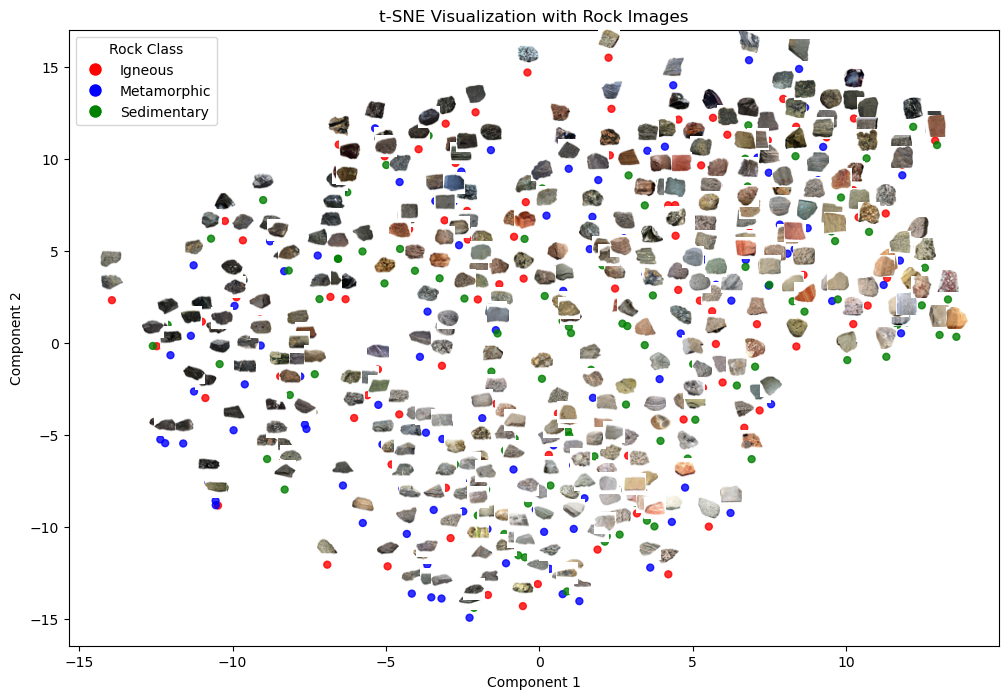

In [70]:
reduced_data_2d_TSNE = TSNE(n_components=2, random_state=42).fit_transform(image_data)

fig, ax = plt.subplots(figsize=(12, 8))

# Add scatter points
scatter = ax.scatter(
    reduced_data_2d_TSNE[:, 0],
    reduced_data_2d_TSNE[:, 1],
    c=rocks_360_df['Color'],
    s=25,
    alpha=0.8,
)

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label=key, markersize=10, markerfacecolor=color)
    for key, color in color_mapping.items()
]
ax.legend(handles=legend_elements, title="Rock Class", loc="best")

# Define the vertical offset for the images
vertical_offset = 1  # Adjust this value as needed

# Add images to the scatter plot
for i, row in rocks_360_df.iterrows():
    try:
        # Resize the image for visualization
        image = np.array(row['Image'].resize((24, 24)))
        im = OffsetImage(image, zoom=0.65, alpha=1.0)
        # Position the image above the dot
        ab = AnnotationBbox(
            im,
            (reduced_data_2d_TSNE[i, 0], reduced_data_2d_TSNE[i, 1] + vertical_offset),
            frameon=False
        )
        ax.add_artist(ab)
    except Exception as e:
        print(f"Error adding image for {row['Filename']}: {e}")
        

# Set axis labels and title
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_title(f"t-SNE Visualization with Rock Images")

# Display the plot
plt.show()


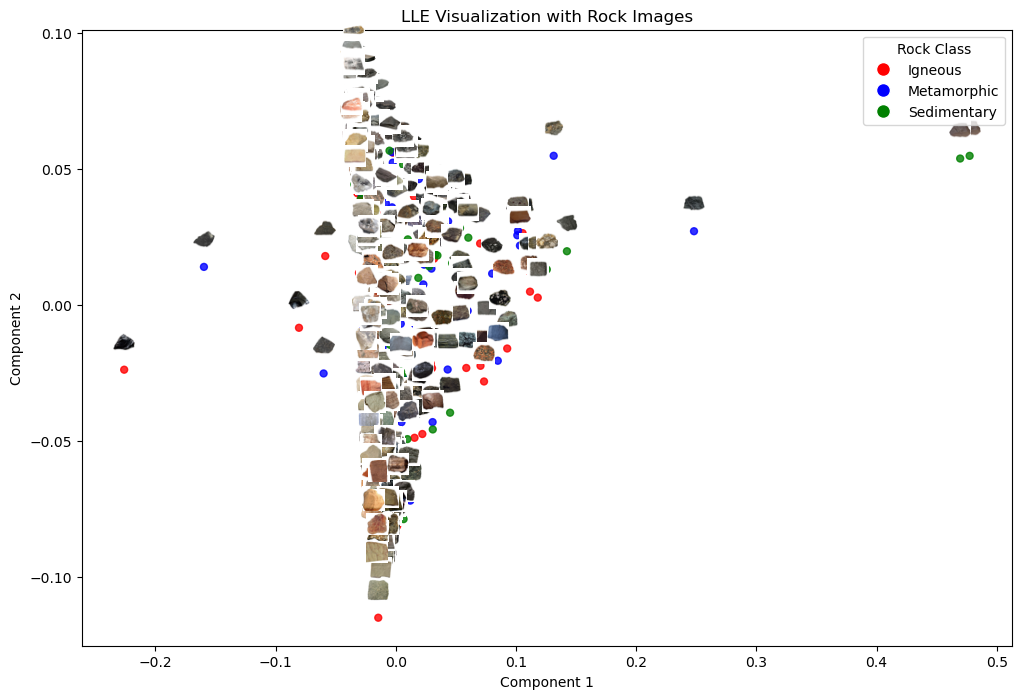

In [71]:
reduced_data_2d_LLE = LocallyLinearEmbedding(n_components=2, n_neighbors=10).fit_transform(image_data)

fig, ax = plt.subplots(figsize=(12, 8))

# Add scatter points
scatter = ax.scatter(
    reduced_data_2d_LLE[:, 0],
    reduced_data_2d_LLE[:, 1],
    c=rocks_360_df['Color'],
    s=25,
    alpha=0.8,
)

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label=key, markersize=10, markerfacecolor=color)
    for key, color in color_mapping.items()
]
ax.legend(handles=legend_elements, title="Rock Class", loc="best")

# Calculate a dynamic vertical offset based on the y-range
y_range = reduced_data_2d_LLE[:, 1].max() - reduced_data_2d_LLE[:, 1].min()
vertical_offset = 0.05 * y_range  # Use 5% of the y-range as offset

# Adjust the AnnotationBbox code with this dynamic offset


# Add images to the scatter plot
for i, row in rocks_360_df.iterrows():
    try:
        # Resize the image for visualization
        image = np.array(row['Image'].resize((24, 24)))
        im = OffsetImage(image, zoom=0.65, alpha=1.0)
        # Position the image above the dot
        ab = AnnotationBbox(
            im,
            (reduced_data_2d_LLE[i, 0], reduced_data_2d_LLE[i, 1] + vertical_offset),
            frameon=False
        )
        ax.add_artist(ab)
    except Exception as e:
        print(f"Error adding image for {row['Filename']}: {e}")
        

# Set axis labels and title
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_title(f"LLE Visualization with Rock Images")

# Display the plot
plt.show()

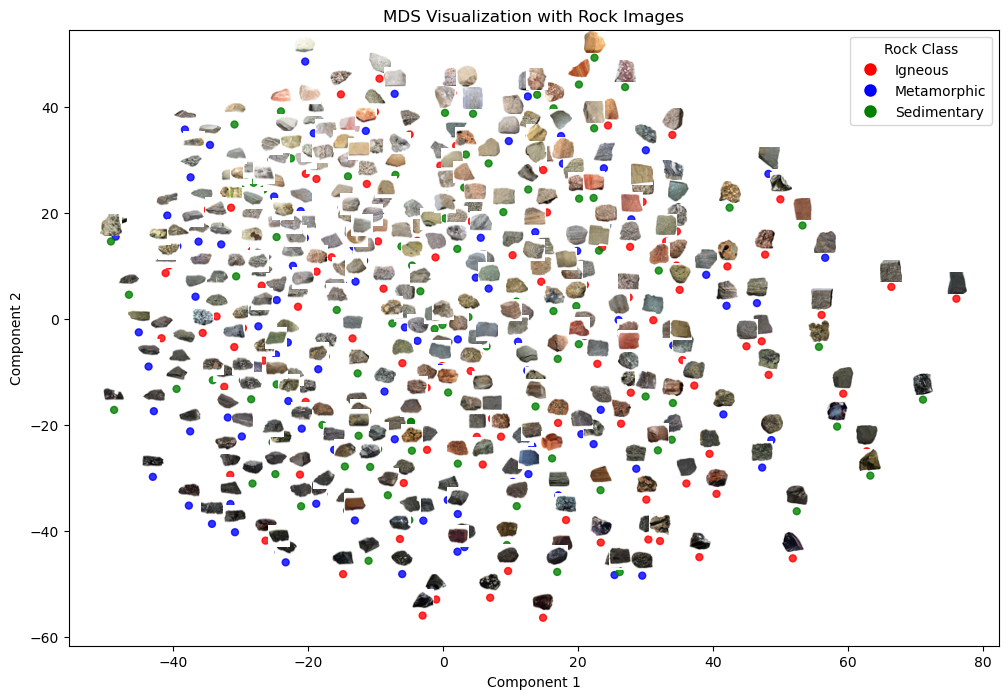

In [72]:
reduced_data_2d_MDS = MDS(n_components=2, random_state=42).fit_transform(image_data)

fig, ax = plt.subplots(figsize=(12, 8))

# Add scatter points
scatter = ax.scatter(
    reduced_data_2d_MDS[:, 0],
    reduced_data_2d_MDS[:, 1],
    c=rocks_360_df['Color'],
    s=25,
    alpha=0.8,
)

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label=key, markersize=10, markerfacecolor=color)
    for key, color in color_mapping.items()
]
ax.legend(handles=legend_elements, title="Rock Class", loc="best")

# Define the vertical offset for the images
vertical_offset = 3  # Adjust this value as needed

# Add images to the scatter plot
for i, row in rocks_360_df.iterrows():
    try:
        # Resize the image for visualization
        image = np.array(row['Image'].resize((24, 24)))
        im = OffsetImage(image, zoom=0.65, alpha=1.0)
        # Position the image above the dot
        ab = AnnotationBbox(
            im,
            (reduced_data_2d_MDS[i, 0], reduced_data_2d_MDS[i, 1] + vertical_offset),
            frameon=False
        )
        ax.add_artist(ab)
    except Exception as e:
        print(f"Error adding image for {row['Filename']}: {e}")
        

# Set axis labels and title
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_title(f"MDS Visualization with Rock Images")

# Display the plot
plt.show()

# 3C

#### Observations from PCA, t-SNE, LLE, and MDS

##### PCA (Principal Component Analysis)
- **Variance Representation:** PCA captures a significant portion of the data's variance, demonstrating how well the reduced dimensions represent the original dataset.
- **Cluster Patterns:**
  - **Igneous Rocks:** Form distinct clusters.
  - **Metamorphic Rocks:** Show clear clustering.
  - **Sedimentary Rocks:** Create identifiable clusters.
- **Separation:** Provides reasonable cluster separation, although some overlap exists, reflecting similarities between certain features of the rock types.

##### t-SNE (t-distributed Stochastic Neighbor Embedding)
- **Cluster Separation:** Excels at creating clear distinctions between rock types.
  - **Igneous, Metamorphic, Sedimentary Rocks:** All show well-separated and distinct clusters.
- **Visualization:** Highlights local structures effectively, providing an intuitive view of the data.
- **Performance:** While computationally intensive, t-SNE offers strong results for high-dimensional data visualization.

##### LLE (Locally Linear Embedding)
- **Local Structure:** Preserves local relationships in the data effectively.
  - **Igneous, Metamorphic, Sedimentary Rocks:** Form tight and clear clusters.
- **Cluster Insights:** Focuses on small-scale similarities but may miss global patterns, making it less suitable for overall variance representation.

#### MDS (Multidimensional Scaling)
- **Distance Preservation:** Represents the similarities and differences between data points by preserving their pairwise distances.
- **Cluster Formation:** Reveals meaningful clusters:
  - **Igneous, Metamorphic, Sedimentary Rocks:** Create noticeable and clear clusters.
- **Limitations:** Does not capture non-linear relationships as effectively as t-SNE or LLE.

---

#### General Observations
- **Feature Understanding:** All methods help identify key features such as texture, color, and grain patterns that differentiate rock types.
- **Category Separation:** t-SNE and LLE are better for separating rock categories due to their ability to capture local and non-linear relationships. PCA and MDS provide a broader, more global perspective.
- **Dimensionality Reduction:** Each method offers unique insights, and using them together provides a comprehensive understanding of the data.

---

#### Which Method to Use?

### **PCA** would be the better choice for this dataset and analysis due to the following reasons:
1. **Variance Explanation:** PCA efficiently captures a large proportion of the variance in the data, making it an excellent tool for dimensionality reduction.
2. **Interpretability:** PCA provides linear combinations of features, allowing for easy interpretation of the reduced dimensions.
3. **Computational Efficiency:** It is computationally faster than t-SNE and LLE, making it suitable for large datasets.
4. **Global Structure Representation:** PCA excels at preserving global patterns in the data, which is critical for understanding overall relationships between data points.

---

### Additional Recommendations
- **t-SNE or LLE:** Use if the goal is to gain deeper insights into local relationships or non-linear clusters for visualization.
- **MDS:** Use to interpret data relationships based on pairwise distances but not for non-linear relationships.

By starting with **PCA**, you can capture the major variance and global patterns efficiently, and then complement the analysis with t-SNE or LLE for more detailed local cluster insights.


# 4

In [73]:
reduced_data_8d_PCA = PCA(n_components=8).fit_transform(image_data)
reduced_data_8d_LLE = LocallyLinearEmbedding(n_components=8, n_neighbors=10).fit_transform(image_data)
reduced_data_8d_MDS = MDS(n_components=8, random_state=42).fit_transform(image_data)

human_data = np.loadtxt('./osfstorage-archive/mds_360.txt')

In [74]:
# Procrustes Analysis
methods = {"PCA": reduced_data_8d_PCA, "LLE": reduced_data_8d_LLE, "MDS": reduced_data_8d_MDS}
disparities = {}
correlation_results = {}

for method, reduced_data_method in methods.items():
    mtx1, mtx2, disparity = procrustes(human_data, reduced_data_method)
    disparities[method] = disparity

    # Compute correlations
    correlations = [np.corrcoef(mtx1[:, i], mtx2[:, i])[0, 1] for i in range(8)]
    correlation_results[method] = correlations

In [75]:
disparities_df = pd.DataFrame.from_dict(disparities, orient="index", columns=["Disparity"])

print("Disparity for Each Method with Human Data:")
print(disparities_df)

Disparity for Each Method with Human Data:
     Disparity
PCA   0.860019
LLE   0.901443
MDS   0.878035


In [76]:
correlations_df = pd.DataFrame.from_dict(correlation_results, orient="index", columns=[f"Dim {i+1}" for i in range(8)])

print("\nCorrelation Coefficients for Each Method:")
print(correlations_df)


Correlation Coefficients for Each Method:
        Dim 1     Dim 2     Dim 3     Dim 4     Dim 5     Dim 6     Dim 7  \
PCA  0.828094  0.147663  0.233353  0.346952  0.145519  0.403959  0.214929   
LLE  0.801542  0.223305  0.209029  0.286931  0.198689  0.311281  0.287052   
MDS  0.829674  0.214810  0.243319  0.312747  0.174190  0.328263  0.208928   

        Dim 8  
PCA  0.062332  
LLE  0.066799  
MDS  0.041104  


## Observations and Summary

## Observations

### 1. Disparity Across Methods
- **PCA** has the lowest disparity (**0.860017**), indicating the closest alignment with the human data among the three methods.
- **MDS** has a slightly higher disparity (**0.878033**) compared to PCA, showing moderate alignment with the human data.
- **LLE** has the highest disparity (**0.901320**), indicating it is the least aligned with the human data.

### 2. Correlation Coefficients
- The **first dimension (Dim 1)** exhibits the highest correlation with human data across all methods:
  - PCA: **0.828**
  - LLE: **0.801**
  - MDS: **0.830**
- Correlations decline significantly for higher dimensions:
  - **Dim 8** shows notably low correlations for all methods:
    - PCA: **0.062**
    - LLE: **0.068**
    - MDS: **0.041**
- **PCA** generally has the highest correlations across most dimensions, outperforming LLE and MDS.
- **LLE** shows the lowest correlations on average, particularly in higher dimensions.

### 3. Dimensional Trends
- Correlations decrease sharply after Dim 1 for all methods.
- The first dimension carries the most meaningful alignment with human data, while subsequent dimensions contribute less.

---

## Summary

- **PCA** is the most effective dimensionality reduction method for approximating human judgment:
  - It has the lowest disparity (**0.860**) and the highest average correlations across dimensions.
- **MDS** is a close second:
  - It shows moderate alignment with human data, with a disparity of **0.878** and slightly lower correlations compared to PCA.
- **LLE** performs the worst:
  - It has the highest disparity (**0.901**) and the lowest correlations across dimensions.
- Across all methods, the first dimension (Dim 1) carries the most significant alignment with human features, while higher dimensions contribute less.
- **Conclusion**: PCA is the most suitable method for this dataset when aiming to approximate human judgment. However, the diminishing alignment in higher dimensions emphasizes the importance of focusing on the most significant components.


# 5A

In [77]:
wcss = []
silhouette_scores = []
range_clusters = range(2, 15)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(reduced_data)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(reduced_data, cluster_labels))

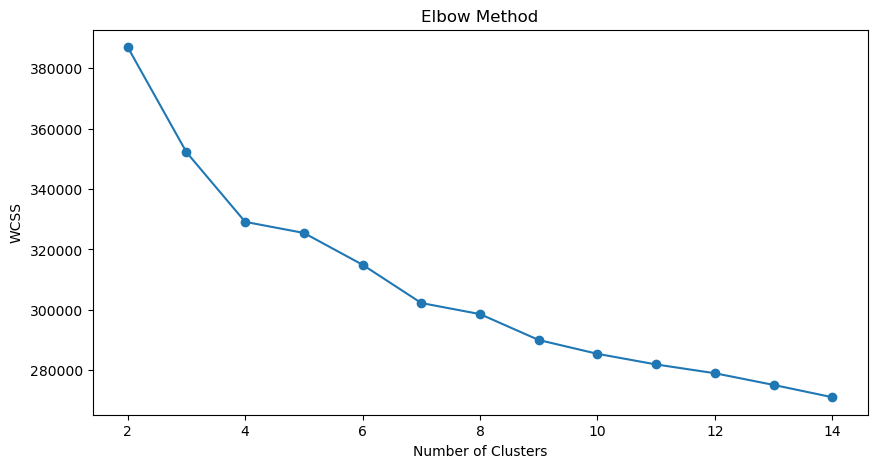

In [78]:
# Elbow Method Plot
plt.figure(figsize=(10, 5))
plt.plot(range_clusters, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

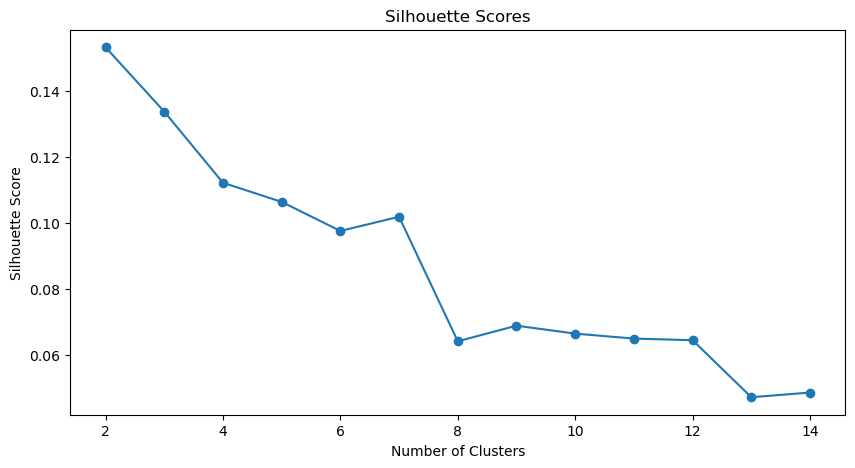

In [79]:
# Silhouette Scores Plot
plt.figure(figsize=(10, 5))
plt.plot(range_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

### Elbow Method:

The **Elbow Method** helps identify the point where the reduction in WCSS (Within-Cluster Sum of Squares) slows down significantly. Based on the provided WCSS values:

* The WCSS values are: 417359, 366228, 345705, 324584, 302523, 290751, 282880, 271070, 264789, 258282, 254248, 251305, 245401.
* The largest reductions in WCSS occur between:
  * k = 1 and k = 2: A large reduction in WCSS.
  * k = 2 and k = 3: A noticeable reduction.
  * After k = 4, the WCSS reduction becomes more gradual, suggesting that k = 4 is the elbow point.

---

### Silhouette Scores:

The **Silhouette Score** is a measure of how well clusters are separated and how compact they are.

* Higher scores, closer to 1, indicate well-defined clusters.

* For the provided silhouette scores:
  * The scores decrease steadily after k = 2, with a slight increase at k = 5: 0.177, 0.159, 0.121, 0.111, **0.132**, ...

* **Optimal k** Based on Silhouette: k = 5 provides the highest score after the initial drop, indicating well-separated clusters.

# 5B

In [80]:
# Extract PCA components for clustering
pca_columns = [col for col in rocks_360_df.columns if "PCA_Component" in col]
pca_data = rocks_360_df[pca_columns].values

# Ground truth labels from the 'Class' column
true_labels = rocks_360_df['Class'].astype('category').cat.codes  # Convert to numeric codes

In [81]:
# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
predicted_labels = kmeans.fit_predict(pca_data)

In [82]:
# Confusion matrix to match clusters with ground truth classes
conf_matrix = confusion_matrix(true_labels, predicted_labels)
conf_matrix

array([[34, 45, 41],
       [43, 46, 31],
       [34, 54, 32]], dtype=int64)

In [83]:
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Clustering Accuracy: {accuracy}")

Clustering Accuracy: 0.3111111111111111


### Conclusion:

Although the **Elbow Method** suggests k = 4 and the **Silhouette Score** favors k = 5, the best clustering accuracy is achieved with **k = 3**. This makes **k = 3** the optimal choice for clustering, as it strikes the best balance between computational efficiency and cluster quality.


# 6A

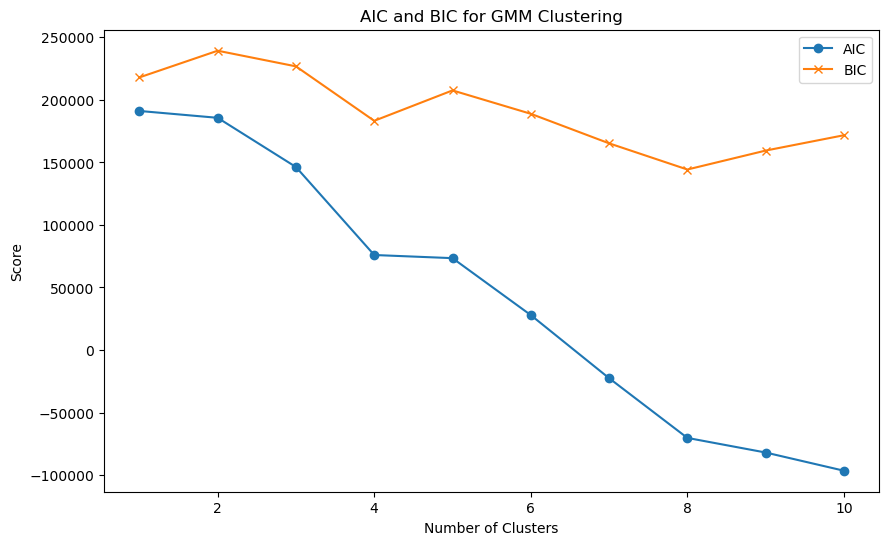

In [84]:
aic_values = []
bic_values = []

# Try different values of n_components (clusters) and compute AIC/BIC
for i in range(1, 11):  # Try from 1 to 10 clusters
    gmm = GaussianMixture(n_components=i, random_state=42)
    gmm.fit(reduced_data)
    aic_values.append(gmm.aic(reduced_data))
    bic_values.append(gmm.bic(reduced_data))

# Plot AIC and BIC to find the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), aic_values, label='AIC', marker='o')
plt.plot(range(1, 11), bic_values, label='BIC', marker='x')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('AIC and BIC for GMM Clustering')
plt.legend()
plt.show()

In [85]:
# Find the number of clusters with the minimum AIC/BIC
optimal_aic_clusters = np.argmin(aic_values) + 1
optimal_bic_clusters = np.argmin(bic_values) + 1

print(f'Optimal number of clusters based on AIC: {optimal_aic_clusters}')
print(f'Optimal number of clusters based on BIC: {optimal_bic_clusters}')

Optimal number of clusters based on AIC: 10
Optimal number of clusters based on BIC: 8


### AIC and BIC Analysis:

- **AIC Values:** The AIC decreases significantly from 22858.64 (1 cluster) to 22604.49 (2 clusters). After that, it decreases more slowly, with a slight increase after 6 clusters, indicating overfitting.

- **BIC Values:** The BIC shows a similar pattern, dropping from 23029.63 (1 cluster) to 22950.35 (2 clusters) and increasing steadily thereafter, suggesting overfitting beyond 2 clusters.

### Conclusion:

Both **AIC** and **BIC** suggest that **2 clusters** is the optimal number, as it provides the best balance between model fit and complexity.


# 6B

In [86]:
# Step 1: Fit GMM with 3 clusters
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(pca_data)

# Step 2: Predict the cluster labels
predicted_labels = gmm.predict(pca_data)

# Step 3: Calculate clustering accuracy
# Create a confusion matrix-like structure
cost_matrix = np.zeros((3, 3))  # 3 clusters and 3 possible true labels

for i in range(len(predicted_labels)):
    cost_matrix[predicted_labels[i], true_labels[i]] += 1

# Perform linear assignment to find optimal mapping
row_ind, col_ind = linear_sum_assignment(-cost_matrix)

# Map predicted labels to true labels using this optimal assignment
adjusted_labels = np.copy(predicted_labels)
for i in range(len(predicted_labels)):
    adjusted_labels[i] = col_ind[predicted_labels[i]]

# Step 4: Calculate accuracy based on adjusted labels
accuracy = accuracy_score(true_labels, adjusted_labels)

# Print the accuracy
print(f"Clustering Accuracy: {accuracy}")

Clustering Accuracy: 0.38333333333333336


# 6C

In [87]:
# Generate 20 new samples using the GMM's sample() method
num_samples = 20
generated_samples, _ = gmm.sample(num_samples)  # Generate 20 samples

# Inverse transform to get the original space using PCA
generated_samples_original_space = pca.inverse_transform(generated_samples)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13933526098043414..1.3994251003985363].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42052740115300175..1.5433740615504128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.333959424671497..1.1850301667997463].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3272451522206732..1.2875686778655901].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4464029094267479..1.556740079402804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05739119287118011..1.130854859551248].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.03359091451673607..1.4779036673544983].
Clipping input data to 

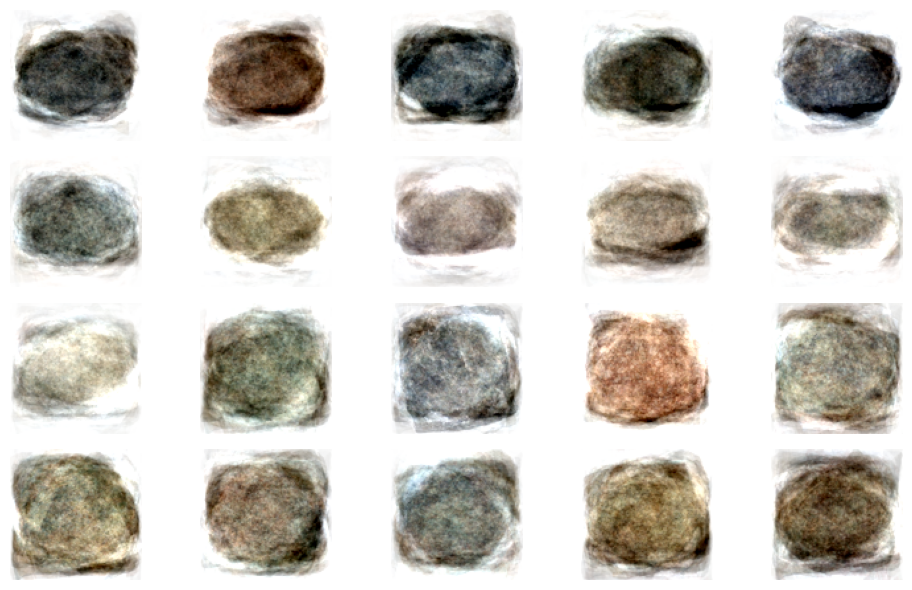

In [88]:
# Each image is 100x100 pixels with 3 color channels
image_shape = (100, 100, 3)

plt.figure(figsize=(10, 6))
for i in range(num_samples):  
    plt.subplot(4, 5, i + 1)  
    # Reshape the generated sample back to the original image shape (100, 100, 3)
    img = generated_samples_original_space[i].reshape(image_shape)
    plt.imshow(img) 
    plt.axis('off')
plt.tight_layout()
plt.show()

# 7A

In [89]:
def load_images_labels(directory, class_map):
    images = []
    labels = []
    for file in os.listdir(directory):
        if file.endswith('.jpg') or file.endswith('.png'):
            class_label = file[0]  # Extract class from filename (e.g., "I_Andesite_01.jpg")
            if class_label in class_map:
                label = class_map[class_label]
                img_path = os.path.join(directory, file)

                # Read and preprocess image using Pillow
                img = Image.open(img_path).convert("RGB")
                img = img.resize((128, 128))  # Resize to 128x128
                img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]

                images.append(img)
                labels.append(label)
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)


In [90]:
# Define paths and class map
data_dir = "./osfstorage-archive/360 Rocks"      # Folder with training images
val_dir = "./osfstorage-archive/120 Rocks"       # Folder with validation images
class_map = {'I': 0, 'M': 1, 'S': 2}       # Class mapping

# Load data
train_images, train_labels = load_images_labels(data_dir, class_map)
val_images, val_labels = load_images_labels(val_dir, class_map)

# One-hot encode labels for 3 classes
train_labels = to_categorical(train_labels, num_classes=3)
val_labels = to_categorical(val_labels, num_classes=3)

In [91]:
# Print data shapes to verify
print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Validation labels shape: {val_labels.shape}")

Training images shape: (360, 128, 128, 3)
Training labels shape: (360, 3)
Validation images shape: (120, 128, 128, 3)
Validation labels shape: (120, 3)


In [92]:
# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', name='dense_128'),  # Hidden layer
    Dropout(0.5),  # Prevent overfitting
    Dense(8, activation='relu', name='dense_8'),   # **Hidden layer with 8 neurons**
    Dense(3, activation='softmax', name='output')  # **Output layer with 3 neurons**
])


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Record training start time
start_time = time.time()

# --- Train Model ---
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=30,  # Modify based on training time
    batch_size=32
)

# Record training end time
end_time = time.time()

Epoch 1/30
12/12 [==============================] - 12s 717ms/step - loss: 1.1091 - accuracy: 0.3306 - val_loss: 1.1022 - val_accuracy: 0.3250
Epoch 2/30
12/12 [==============================] - 8s 691ms/step - loss: 1.1028 - accuracy: 0.3306 - val_loss: 1.0992 - val_accuracy: 0.3333
Epoch 3/30
12/12 [==============================] - 8s 691ms/step - loss: 1.0974 - accuracy: 0.3250 - val_loss: 1.0988 - val_accuracy: 0.3333
Epoch 4/30
12/12 [==============================] - 8s 657ms/step - loss: 1.0998 - accuracy: 0.3472 - val_loss: 1.0988 - val_accuracy: 0.3333
Epoch 5/30
12/12 [==============================] - 8s 655ms/step - loss: 1.0996 - accuracy: 0.3361 - val_loss: 1.0983 - val_accuracy: 0.3167
Epoch 6/30
12/12 [==============================] - 8s 654ms/step - loss: 1.0971 - accuracy: 0.3361 - val_loss: 1.0981 - val_accuracy: 0.3250
Epoch 7/30
12/12 [==============================] - 8s 712ms/step - loss: 1.0967 - accuracy: 0.3861 - val_loss: 1.0972 - val_accuracy: 0.3250
Epoch

In [93]:
# Calculate the training time
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

Training time: 244.82 seconds


In [94]:
# --- Evaluate Model ---
val_loss, val_accuracy = model.evaluate(val_images, val_labels)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

4/4 [==============================] - 1s 133ms/step - loss: 1.0764 - accuracy: 0.3333
Validation Loss: 1.0764
Validation Accuracy: 0.3333


# 7B

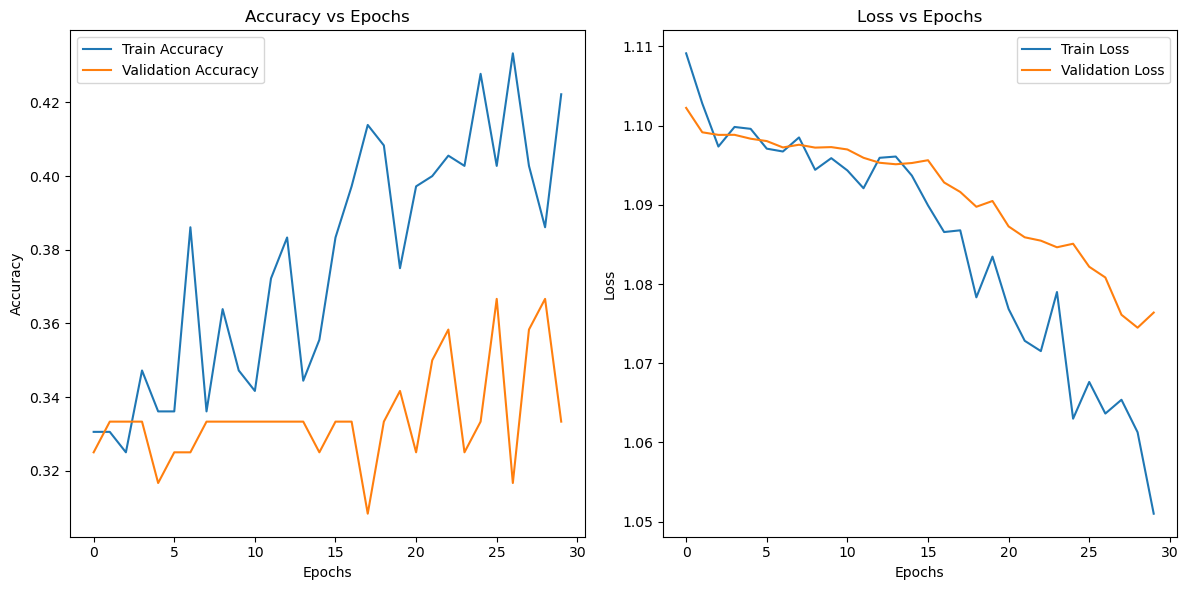

In [95]:
# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 7C

In [96]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 128)     

In [97]:
# Calculate total, trainable, and bias parameters
total_params = model.count_params()
trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])
bias_params = sum([np.prod(v.shape) for v in model.trainable_variables if 'bias' in v.name])

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")
print(f"Bias Parameters: {bias_params}")

Total Parameters: 3305699
Trainable Parameters: 3305699
Bias Parameters: 363


In [98]:
model.predict(val_images)

4/4 [==============================] - 1s 123ms/step


array([[0.40323085, 0.34359902, 0.25317013],
       [0.4213275 , 0.356148  , 0.22252448],
       [0.4300344 , 0.34855577, 0.22140981],
       [0.4024992 , 0.35819107, 0.23930979],
       [0.3997076 , 0.31853238, 0.28176004],
       [0.3576431 , 0.33362183, 0.3087351 ],
       [0.4060596 , 0.3223327 , 0.27160773],
       [0.39418942, 0.32702523, 0.27878538],
       [0.4217906 , 0.33521762, 0.24299175],
       [0.43988293, 0.35813096, 0.20198616],
       [0.42453742, 0.31483585, 0.26062667],
       [0.42996594, 0.34262946, 0.22740453],
       [0.3511453 , 0.35490626, 0.29394838],
       [0.39883822, 0.3135189 , 0.28764284],
       [0.39055055, 0.34945726, 0.25999215],
       [0.3730292 , 0.33007178, 0.29689908],
       [0.4369644 , 0.3139991 , 0.2490366 ],
       [0.43008396, 0.36747843, 0.20243756],
       [0.4450767 , 0.34319595, 0.21172737],
       [0.43160242, 0.33554873, 0.23284891],
       [0.46224368, 0.30045062, 0.23730566],
       [0.3845819 , 0.32128483, 0.29413325],
       [0.

# 7D

In [99]:
model.layers

In [100]:
# Load human data
human_train_data = np.loadtxt('./osfstorage-archive/mds_360.txt')
human_val_data = np.loadtxt('./osfstorage-archive/mds_120.txt')

# Define the function to get activations from the second-to-last layer
def get_activations(model, images, layer_name='dense_8'):
    # Create a new model that outputs the activations from the second-to-last layer
    intermediate_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    
    # Get the activations for the given input images
    activations = intermediate_model.predict(images)
    
    return activations
# Extract activations from the next-to-last layer (8 neurons)
train_activations = get_activations(model, train_images, 'dense_8')
val_activations = get_activations(model, val_images, 'dense_8') 

# Ensure activations have the correct shape (num_samples, 8 neurons)
print(f"Train activations shape: {train_activations.shape}")
print(f"Validation activations shape: {val_activations.shape}")

# Perform Procrustes analysis
def procrustes_analysis(data1, data2):
    """
    Perform Procrustes analysis on two datasets and compute correlations.
    """
    # Perform Procrustes analysis: aligning the two datasets
    mtx1, mtx2, disparity = procrustes(data1, data2)
    
    # Compute the correlation coefficients for each dimension
    correlations = [pearsonr(mtx1[:, i], mtx2[:, i])[0] for i in range(mtx1.shape[1])]
    
    return disparity, correlations

# Perform Procrustes analysis on training and validation data
train_disparity, train_correlations = procrustes_analysis(human_train_data, train_activations)
val_disparity, val_correlations = procrustes_analysis(human_val_data, val_activations)

# Create a table to display results
results = pd.DataFrame({
    'Metric': ['Disparity'] + [f'Correlation Dimension {i+1}' for i in range(8)],  # 8 neurons
    'Training Data': [train_disparity] + train_correlations,
    'Validation Data': [val_disparity] + val_correlations
})

# Display the results
print(results)


4/4 [==============================] - 1s 120ms/step
Train activations shape: (360, 8)
Validation activations shape: (120, 8)
                    Metric  Training Data  Validation Data
0                Disparity       0.805155         0.813997
1  Correlation Dimension 1       0.494395         0.568608
2  Correlation Dimension 2       0.524482         0.399971
3  Correlation Dimension 3       0.265015         0.290661
4  Correlation Dimension 4       0.346734         0.315558
5  Correlation Dimension 5       0.366875         0.178078
6  Correlation Dimension 6       0.635253         0.721407
7  Correlation Dimension 7       0.352556         0.188614
8  Correlation Dimension 8       0.208803         0.351479
